# Transcribing handwritten images

## The working details of Connectionist Temporal Classification (CTC) loss

Imagine a scenario where we are transcribing an image that contains the word ab. The
image could look like any of the following and the output is always ab, irrespective of
which of the following three images we choose:

![image.png](../imgs/nlp15.png)

In the next step, we divide the preceding three examples into six time steps, as
follows (where each box represents a time step):

![image.png](../imgs/nlp16.png)

Now, we'll predict the output character in each time step – where the output is the
softmax of probabilities of words present within a vocabulary. Given that we are
performing softmax, let's say the output character at each time step after running the
image through our model (which we will define in the subsequent section) is as in the
following (the output of each cell is provided above the image):

![image.png](../imgs/nlp17.png)

Note that - represents that nothing is present in the corresponding time step.
Furthermore, note that the character b is repeated in two different time steps.

In the final step, we will squash the output (a sequence of characters) that is obtained
by passing our image through the model in such a way that consecutive repeating
characters are squashed into one.

The preceding step of squashing repeating characters' output if there are consecutive
same-character predictions results in a final output as follows:

-a-b-

In another case, where the output is abb, the final output post squashing is expected to
have a separator between the two b characters, an example of which is as follows:

-a-b-b-



## Calculating the CTC loss value

For the problem we are solving in the previous section, let's consider the following
scenario – the probability of having the character in a given time step is provided in
the circles in the following diagram (note that the probabilities add up to 1 in each
time step from t0 to t5):

![nlp](../imgs/nlp18.png)

However, to keep the calculation simple, for us to understand how the CTC loss
value is calculated, let's take a scenario where the image contains only the character
a and not the word ab. Furthermore, we'll assume that there are only three time steps
for simplicity of calculation:

![nlp](../imgs/nlp19.png)

We can obtain the ground truth of a if the softmax in each time step is like any of the
following seven scenarios:

![nlp](../imgs/nlp20.png)

![nlp](../imgs/nlp21.png)

From the preceding results, we can see that the overall probability of obtaining the
ground truth is 0.906.

The rest of the 0.094 corresponds to the probability of the outcome not obtaining the
ground truth.

Let's calculate the binary cross-entropy loss corresponding to the summation of all the
possible ground truths.

CTC loss is the negative logarithm of the overall probability summation of
combinations that result in ground truth = -log(0.906) = 0.1.

In [1]:
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

--2023-08-16 14:49:59--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2023-08-16 14:50:00--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3a5ed45f5ff95387d0384a626.dl.dropboxusercontent.com/cd/0/inline/CB754XNAq5GdmFbCvBblQACynnP7NlY1DbLRW1yK6rtP435mUgM0pjn61Lz0Y56Ex7ybZd8nGBSWIzHct5SkD4GiF7n6ZJrWmdOhOo1rqsgu-gbt0_F5qJgaoBS6S_RWxdUqN7zE6BAaiuaoeqJhqpu0/file# [following]
--2023-08-16 14:50:01--  https://ucb3a5ed45f5ff95387d0384a626.dl.dropboxusercontent.com/cd/0/inline/CB754XNAq5GdmFbCvBblQACynnP7NlY1DbLRW1yK6rtP435mUgM0pjn61Lz0Y56Ex7ybZd8nGBSWIzHct

In [2]:
!pip install torch_snippets torch_summary editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.4/283.4 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [3]:
from torch_snippets import *
from torchsummary import summary
import editdistance

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]
images = Glob('synthetic-data')

In [26]:
len(images)

25132

In [5]:
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'
B,T,V = 64, 32, len(vocab) 
H,W = 32, 128 

In [27]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, preprocess_shape=(H,W), timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]
    def __getitem__(self, ix):
        imgPath = self.items[ix]
        image = cv2.imread(str(imgPath), 0)
        label = fname2label(imgPath)
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")
    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}


In [28]:
from sklearn.model_selection import train_test_split
trn_items, val_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=22)
trn_ds = OCRDataset(trn_items)
val_ds = OCRDataset(val_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

In [29]:
from torch_snippets import Reshape, Permute
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [31]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [32]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [33]:
model = Ocr(len(vocab)).to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 53]               --
|    └─Linear: 2-7                       [-1, 1, 53]             

In [34]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [35]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [36]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 50
log = Report(n_epochs)

In [37]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, trn_loss=loss, trn_char_acc=ca, trn_word_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(pos=pos, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 1.000  trn_char_acc: 0.018  trn_word_acc: 0.000  trn_loss: 3.339  val_loss: 3.074  val_char_acc: 0.133  val_word_acc: 0.000  (22.28s - 1091.74s remaining)


Pred: `se` :: Truth: `represent`

Pred: `se` :: Truth: `third`

Pred: `se` :: Truth: `prevent`

Pred: `se` :: Truth: `attack`

Pred: `e` :: Truth: `real`

EPOCH: 2.000  trn_char_acc: 0.164  trn_word_acc: 0.001  trn_loss: 2.967  val_loss: 2.729  val_char_acc: 0.202  val_word_acc: 0.001  (42.25s - 1013.96s remaining)


Pred: `tie` :: Truth: `friend`

Pred: `pie` :: Truth: `high`

Pred: `pee` :: Truth: `real`

Pred: `ste` :: Truth: `close`

Pred: `see` :: Truth: `organization`

EPOCH: 3.000  trn_char_acc: 0.333  trn_word_acc: 0.015  trn_loss: 2.383  val_loss: 1.702  val_char_acc: 0.509  val_word_acc: 0.065  (62.39s - 977.41s remaining)


Pred: `cdetail` :: Truth: `detail`

Pred: `iteu` :: Truth: `star`

Pred: `weio` :: Truth: `main`

Pred: `admit` :: Truth: `admit`

Pred: `cor` :: Truth: `car`

EPOCH: 4.000  trn_char_acc: 0.645  trn_word_acc: 0.170  trn_loss: 1.449  val_loss: 1.022  val_char_acc: 0.710  val_word_acc: 0.257  (82.74s - 951.54s remaining)


Pred: `auite` :: Truth: `quite`

Pred: `tire` :: Truth: `fire`

Pred: `shppse` :: Truth: `choose`

Pred: `alono` :: Truth: `along`

Pred: `intcpcct` :: Truth: `interest`

EPOCH: 5.000  trn_char_acc: 0.771  trn_word_acc: 0.353  trn_loss: 1.020  val_loss: 0.749  val_char_acc: 0.791  val_word_acc: 0.398  (102.80s - 925.21s remaining)


Pred: `him` :: Truth: `him`

Pred: `reaigon` :: Truth: `region`

Pred: `soal` :: Truth: `goal`

Pred: `stoant` :: Truth: `start`

Pred: `short` :: Truth: `short`

EPOCH: 6.000  trn_char_acc: 0.841  trn_word_acc: 0.496  trn_loss: 0.777  val_loss: 0.604  val_char_acc: 0.830  val_word_acc: 0.500  (122.73s - 900.03s remaining)


Pred: `sitirtion` :: Truth: `situation`

Pred: `catch` :: Truth: `catch`

Pred: `heawy` :: Truth: `heavy`

Pred: `property` :: Truth: `property`

Pred: `wery` :: Truth: `very`

EPOCH: 7.000  trn_char_acc: 0.886  trn_word_acc: 0.616  trn_loss: 0.616  val_loss: 0.474  val_char_acc: 0.873  val_word_acc: 0.585  (142.67s - 876.41s remaining)


Pred: `road` :: Truth: `road`

Pred: `push` :: Truth: `push`

Pred: `sice` :: Truth: `since`

Pred: `evidence` :: Truth: `evidence`

Pred: `auter` :: Truth: `after`

EPOCH: 8.000  trn_char_acc: 0.912  trn_word_acc: 0.687  trn_loss: 0.504  val_loss: 0.405  val_char_acc: 0.888  val_word_acc: 0.638  (162.88s - 855.13s remaining)


Pred: `away` :: Truth: `away`

Pred: `whatever` :: Truth: `whatever`

Pred: `magagine` :: Truth: `magazine`

Pred: `after` :: Truth: `after`

Pred: `form` :: Truth: `form`

EPOCH: 9.000  trn_char_acc: 0.931  trn_word_acc: 0.745  trn_loss: 0.419  val_loss: 0.334  val_char_acc: 0.907  val_word_acc: 0.686  (183.01s - 833.70s remaining)


Pred: `top` :: Truth: `top`

Pred: `hospital` :: Truth: `hospital`

Pred: `support` :: Truth: `support`

Pred: `intenational` :: Truth: `international`

Pred: `traditional` :: Truth: `traditional`

EPOCH: 10.000  trn_char_acc: 0.945  trn_word_acc: 0.790  trn_loss: 0.360  val_loss: 0.313  val_char_acc: 0.914  val_word_acc: 0.703  (203.06s - 812.25s remaining)


Pred: `speckh` :: Truth: `speech`

Pred: `bit` :: Truth: `bit`

Pred: `seek` :: Truth: `seek`

Pred: `apply` :: Truth: `apply`

Pred: `leader` :: Truth: `leader`

EPOCH: 11.000  trn_char_acc: 0.955  trn_word_acc: 0.823  trn_loss: 0.313  val_loss: 0.289  val_char_acc: 0.921  val_word_acc: 0.724  (223.30s - 791.70s remaining)


Pred: `a` :: Truth: `a`

Pred: `stle` :: Truth: `style`

Pred: `everyoooy` :: Truth: `everybody`

Pred: `aded` :: Truth: `add`

Pred: `factor` :: Truth: `factor`

EPOCH: 12.000  trn_char_acc: 0.962  trn_word_acc: 0.845  trn_loss: 0.284  val_loss: 0.260  val_char_acc: 0.927  val_word_acc: 0.752  (243.51s - 771.12s remaining)


Pred: `various` :: Truth: `various`

Pred: `community` :: Truth: `community`

Pred: `reach` :: Truth: `reach`

Pred: `result` :: Truth: `result`

Pred: `learn` :: Truth: `learn`

EPOCH: 13.000  trn_char_acc: 0.969  trn_word_acc: 0.871  trn_loss: 0.247  val_loss: 0.242  val_char_acc: 0.933  val_word_acc: 0.763  (263.55s - 750.09s remaining)


Pred: `every` :: Truth: `every`

Pred: `black` :: Truth: `black`

Pred: `renert` :: Truth: `report`

Pred: `all` :: Truth: `all`

Pred: `wish` :: Truth: `wish`

EPOCH: 14.000  trn_char_acc: 0.973  trn_word_acc: 0.885  trn_loss: 0.223  val_loss: 0.244  val_char_acc: 0.935  val_word_acc: 0.771  (283.50s - 729.01s remaining)


Pred: `I` :: Truth: `I`

Pred: `go` :: Truth: `go`

Pred: `outside` :: Truth: `outside`

Pred: `up` :: Truth: `up`

Pred: `computer` :: Truth: `computer`

EPOCH: 15.000  trn_char_acc: 0.978  trn_word_acc: 0.905  trn_loss: 0.201  val_loss: 0.223  val_char_acc: 0.938  val_word_acc: 0.783  (303.60s - 708.40s remaining)


Pred: `at` :: Truth: `at`

Pred: `today` :: Truth: `today`

Pred: `could` :: Truth: `could`

Pred: `role` :: Truth: `role`

Pred: `station` :: Truth: `station`

EPOCH: 16.000  trn_char_acc: 0.980  trn_word_acc: 0.912  trn_loss: 0.183  val_loss: 0.210  val_char_acc: 0.940  val_word_acc: 0.785  (323.72s - 687.91s remaining)


Pred: `court` :: Truth: `court`

Pred: `but` :: Truth: `but`

Pred: `secand` :: Truth: `second`

Pred: `doctor` :: Truth: `doctor`

Pred: `rich` :: Truth: `rich`

EPOCH: 17.000  trn_char_acc: 0.983  trn_word_acc: 0.925  trn_loss: 0.165  val_loss: 0.220  val_char_acc: 0.941  val_word_acc: 0.789  (343.92s - 667.61s remaining)


Pred: `why` :: Truth: `why`

Pred: `hed` :: Truth: `bed`

Pred: `hal` :: Truth: `local`

Pred: `indeed` :: Truth: `indeed`

Pred: `maintain` :: Truth: `maintain`

EPOCH: 18.000  trn_char_acc: 0.985  trn_word_acc: 0.930  trn_loss: 0.158  val_loss: 0.194  val_char_acc: 0.947  val_word_acc: 0.806  (364.19s - 647.45s remaining)


Pred: `middle` :: Truth: `middle`

Pred: `allaw` :: Truth: `allow`

Pred: `change` :: Truth: `change`

Pred: `brother` :: Truth: `brother`

Pred: `anaiysis` :: Truth: `analysis`

EPOCH: 19.000  trn_char_acc: 0.987  trn_word_acc: 0.941  trn_loss: 0.145  val_loss: 0.191  val_char_acc: 0.947  val_word_acc: 0.806  (384.50s - 627.34s remaining)


Pred: `security` :: Truth: `security`

Pred: `education` :: Truth: `education`

Pred: `young` :: Truth: `young`

Pred: `eight` :: Truth: `eight`

Pred: `growth` :: Truth: `growth`

EPOCH: 20.000  trn_char_acc: 0.988  trn_word_acc: 0.947  trn_loss: 0.139  val_loss: 0.189  val_char_acc: 0.948  val_word_acc: 0.813  (404.83s - 607.25s remaining)


Pred: `kegy` :: Truth: `leg`

Pred: `gas` :: Truth: `gas`

Pred: `count` :: Truth: `court`

Pred: `lot` :: Truth: `lot`

Pred: `stamdard` :: Truth: `standard`

EPOCH: 21.000  trn_char_acc: 0.989  trn_word_acc: 0.951  trn_loss: 0.127  val_loss: 0.200  val_char_acc: 0.946  val_word_acc: 0.803  (425.18s - 587.15s remaining)


Pred: `malr` :: Truth: `man`

Pred: `two` :: Truth: `two`

Pred: `rule` :: Truth: `rule`

Pred: `lealc` :: Truth: `local`

Pred: `nair` :: Truth: `hair`

EPOCH: 22.000  trn_char_acc: 0.991  trn_word_acc: 0.956  trn_loss: 0.119  val_loss: 0.183  val_char_acc: 0.952  val_word_acc: 0.828  (445.47s - 566.96s remaining)


Pred: `season` :: Truth: `season`

Pred: `free` :: Truth: `free`

Pred: `his` :: Truth: `his`

Pred: `rerpoud` :: Truth: `respond`

Pred: `loss` :: Truth: `loss`

EPOCH: 23.000  trn_char_acc: 0.991  trn_word_acc: 0.958  trn_loss: 0.114  val_loss: 0.170  val_char_acc: 0.954  val_word_acc: 0.833  (465.79s - 546.80s remaining)


Pred: `heath` :: Truth: `health`

Pred: `office` :: Truth: `office`

Pred: `opportinity` :: Truth: `opportunity`

Pred: `ail` :: Truth: `oil`

Pred: `cup` :: Truth: `cup`

EPOCH: 24.000  trn_char_acc: 0.992  trn_word_acc: 0.960  trn_loss: 0.112  val_loss: 0.171  val_char_acc: 0.953  val_word_acc: 0.827  (486.20s - 526.71s remaining)


Pred: `lengunge` :: Truth: `language`

Pred: `shoulder` :: Truth: `shoulder`

Pred: `government` :: Truth: `government`

Pred: `various` :: Truth: `various`

Pred: `which` :: Truth: `which`

EPOCH: 25.000  trn_char_acc: 0.993  trn_word_acc: 0.965  trn_loss: 0.104  val_loss: 0.182  val_char_acc: 0.952  val_word_acc: 0.823  (506.56s - 506.56s remaining)


Pred: `secand` :: Truth: `second`

Pred: `fast` :: Truth: `fast`

Pred: `offer` :: Truth: `offer`

Pred: `remnevent` :: Truth: `represent`

Pred: `huge` :: Truth: `huge`

EPOCH: 26.000  trn_char_acc: 0.994  trn_word_acc: 0.967  trn_loss: 0.099  val_loss: 0.170  val_char_acc: 0.956  val_word_acc: 0.839  (527.16s - 486.61s remaining)


Pred: `ever` :: Truth: `ever`

Pred: `without` :: Truth: `without`

Pred: `shouold` :: Truth: `should`

Pred: `her` :: Truth: `her`

Pred: `after` :: Truth: `after`

EPOCH: 27.000  trn_char_acc: 0.994  trn_word_acc: 0.971  trn_loss: 0.091  val_loss: 0.171  val_char_acc: 0.956  val_word_acc: 0.839  (547.42s - 466.32s remaining)


Pred: `statement` :: Truth: `statement`

Pred: `another` :: Truth: `another`

Pred: `sped` :: Truth: `spend`

Pred: `power` :: Truth: `power`

Pred: `Mrs` :: Truth: `Mrs`

EPOCH: 28.000  trn_char_acc: 0.995  trn_word_acc: 0.974  trn_loss: 0.089  val_loss: 0.172  val_char_acc: 0.956  val_word_acc: 0.836  (567.79s - 446.12s remaining)


Pred: `southern` :: Truth: `southern`

Pred: `rise` :: Truth: `rise`

Pred: `tax` :: Truth: `tax`

Pred: `cup` :: Truth: `cup`

Pred: `toward` :: Truth: `toward`

EPOCH: 29.000  trn_char_acc: 0.995  trn_word_acc: 0.977  trn_loss: 0.088  val_loss: 0.171  val_char_acc: 0.956  val_word_acc: 0.840  (588.15s - 425.90s remaining)


Pred: `fod` :: Truth: `foot`

Pred: `say` :: Truth: `say`

Pred: `across` :: Truth: `across`

Pred: `cortain` :: Truth: `contain`

Pred: `relutiongly` :: Truth: `relationship`

EPOCH: 30.000  trn_char_acc: 0.996  trn_word_acc: 0.977  trn_loss: 0.084  val_loss: 0.189  val_char_acc: 0.956  val_word_acc: 0.834  (608.51s - 405.67s remaining)


Pred: `end` :: Truth: `end`

Pred: `anove` :: Truth: `anyone`

Pred: `sie` :: Truth: `size`

Pred: `language` :: Truth: `language`

Pred: `seem` :: Truth: `seem`

EPOCH: 31.000  trn_char_acc: 0.997  trn_word_acc: 0.981  trn_loss: 0.077  val_loss: 0.160  val_char_acc: 0.958  val_word_acc: 0.847  (628.71s - 385.34s remaining)


Pred: `if` :: Truth: `if`

Pred: `give` :: Truth: `give`

Pred: `per` :: Truth: `per`

Pred: `masket` :: Truth: `market`

Pred: `may` :: Truth: `may`

EPOCH: 32.000  trn_char_acc: 0.997  trn_word_acc: 0.982  trn_loss: 0.074  val_loss: 0.162  val_char_acc: 0.956  val_word_acc: 0.837  (648.94s - 365.03s remaining)


Pred: `month` :: Truth: `month`

Pred: `heavy` :: Truth: `heavy`

Pred: `figure` :: Truth: `figure`

Pred: `how` :: Truth: `how`

Pred: `fast` :: Truth: `fast`

EPOCH: 33.000  trn_char_acc: 0.997  trn_word_acc: 0.982  trn_loss: 0.075  val_loss: 0.174  val_char_acc: 0.958  val_word_acc: 0.844  (669.34s - 344.81s remaining)


Pred: `hatel` :: Truth: `hotel`

Pred: `minute` :: Truth: `minute`

Pred: `push` :: Truth: `push`

Pred: `paper` :: Truth: `paper`

Pred: `staff` :: Truth: `staff`

EPOCH: 34.000  trn_char_acc: 0.997  trn_word_acc: 0.985  trn_loss: 0.066  val_loss: 0.165  val_char_acc: 0.959  val_word_acc: 0.848  (689.60s - 324.52s remaining)


Pred: `TV` :: Truth: `TV`

Pred: `middle` :: Truth: `middle`

Pred: `wish` :: Truth: `wish`

Pred: `low` :: Truth: `low`

Pred: `design` :: Truth: `design`

EPOCH: 35.000  trn_char_acc: 0.997  trn_word_acc: 0.985  trn_loss: 0.067  val_loss: 0.157  val_char_acc: 0.961  val_word_acc: 0.853  (709.96s - 304.27s remaining)


Pred: `throw` :: Truth: `throw`

Pred: `child` :: Truth: `child`

Pred: `themselves` :: Truth: `themselves`

Pred: `per` :: Truth: `per`

Pred: `first` :: Truth: `first`

EPOCH: 36.000  trn_char_acc: 0.997  trn_word_acc: 0.984  trn_loss: 0.069  val_loss: 0.165  val_char_acc: 0.959  val_word_acc: 0.847  (730.32s - 284.01s remaining)


Pred: `open` :: Truth: `open`

Pred: `statment` :: Truth: `statement`

Pred: `sound` :: Truth: `sound`

Pred: `media` :: Truth: `media`

Pred: `either` :: Truth: `either`

EPOCH: 37.000  trn_char_acc: 0.998  trn_word_acc: 0.986  trn_loss: 0.066  val_loss: 0.161  val_char_acc: 0.962  val_word_acc: 0.856  (750.60s - 263.72s remaining)


Pred: `fund` :: Truth: `fund`

Pred: `important` :: Truth: `important`

Pred: `PM` :: Truth: `PM`

Pred: `argue` :: Truth: `argue`

Pred: `full` :: Truth: `full`

EPOCH: 38.000  trn_char_acc: 0.998  trn_word_acc: 0.988  trn_loss: 0.061  val_loss: 0.159  val_char_acc: 0.960  val_word_acc: 0.855  (770.79s - 243.41s remaining)


Pred: `reality` :: Truth: `reality`

Pred: `Mr` :: Truth: `Mr`

Pred: `whom` :: Truth: `whom`

Pred: `item` :: Truth: `item`

Pred: `memory` :: Truth: `memory`

EPOCH: 39.000  trn_char_acc: 0.998  trn_word_acc: 0.988  trn_loss: 0.062  val_loss: 0.149  val_char_acc: 0.960  val_word_acc: 0.857  (790.92s - 223.08s remaining)


Pred: `ouwr` :: Truth: `our`

Pred: `item` :: Truth: `item`

Pred: `position` :: Truth: `position`

Pred: `late` :: Truth: `late`

Pred: `pay` :: Truth: `pay`

EPOCH: 40.000  trn_char_acc: 0.998  trn_word_acc: 0.989  trn_loss: 0.056  val_loss: 0.158  val_char_acc: 0.960  val_word_acc: 0.857  (811.21s - 202.80s remaining)


Pred: `cause` :: Truth: `cause`

Pred: `method` :: Truth: `method`

Pred: `same` :: Truth: `same`

Pred: `car` :: Truth: `car`

Pred: `change` :: Truth: `change`

EPOCH: 41.000  trn_char_acc: 0.998  trn_word_acc: 0.989  trn_loss: 0.059  val_loss: 0.163  val_char_acc: 0.961  val_word_acc: 0.855  (831.51s - 182.53s remaining)


Pred: `chair` :: Truth: `chair`

Pred: `issue` :: Truth: `issue`

Pred: `positicn` :: Truth: `position`

Pred: `stydent` :: Truth: `student`

Pred: `name` :: Truth: `name`

EPOCH: 42.000  trn_char_acc: 0.998  trn_word_acc: 0.990  trn_loss: 0.055  val_loss: 0.153  val_char_acc: 0.961  val_word_acc: 0.860  (851.83s - 162.25s remaining)


Pred: `behavior` :: Truth: `behavior`

Pred: `language` :: Truth: `language`

Pred: `list` :: Truth: `list`

Pred: `office` :: Truth: `office`

Pred: `season` :: Truth: `season`

EPOCH: 43.000  trn_char_acc: 0.999  trn_word_acc: 0.991  trn_loss: 0.054  val_loss: 0.160  val_char_acc: 0.962  val_word_acc: 0.862  (872.22s - 141.99s remaining)


Pred: `window` :: Truth: `window`

Pred: `particlar` :: Truth: `particular`

Pred: `none` :: Truth: `none`

Pred: `base` :: Truth: `base`

Pred: `playr` :: Truth: `plan`

EPOCH: 44.000  trn_char_acc: 0.998  trn_word_acc: 0.991  trn_loss: 0.054  val_loss: 0.165  val_char_acc: 0.961  val_word_acc: 0.856  (892.55s - 121.71s remaining)


Pred: `business` :: Truth: `business`

Pred: `mean` :: Truth: `mean`

Pred: `rest` :: Truth: `rest`

Pred: `trial` :: Truth: `trial`

Pred: `most` :: Truth: `most`

EPOCH: 45.000  trn_char_acc: 0.999  trn_word_acc: 0.992  trn_loss: 0.053  val_loss: 0.150  val_char_acc: 0.962  val_word_acc: 0.862  (912.90s - 101.43s remaining)


Pred: `lot` :: Truth: `lot`

Pred: `plant` :: Truth: `plant`

Pred: `car` :: Truth: `can`

Pred: `say` :: Truth: `say`

Pred: `design` :: Truth: `design`

EPOCH: 46.000  trn_char_acc: 0.999  trn_word_acc: 0.992  trn_loss: 0.051  val_loss: 0.159  val_char_acc: 0.960  val_word_acc: 0.852  (933.39s - 81.16s remaining)


Pred: `growth` :: Truth: `growth`

Pred: `internatioal` :: Truth: `international`

Pred: `spring` :: Truth: `spring`

Pred: `hand` :: Truth: `hand`

Pred: `enviromental` :: Truth: `environmental`

EPOCH: 47.000  trn_char_acc: 0.999  trn_word_acc: 0.993  trn_loss: 0.047  val_loss: 0.151  val_char_acc: 0.962  val_word_acc: 0.861  (953.76s - 60.88s remaining)


Pred: `street` :: Truth: `street`

Pred: `lawyer` :: Truth: `lawyer`

Pred: `wish` :: Truth: `wish`

Pred: `not` :: Truth: `not`

Pred: `create` :: Truth: `create`

EPOCH: 48.000  trn_char_acc: 0.999  trn_word_acc: 0.993  trn_loss: 0.045  val_loss: 0.144  val_char_acc: 0.964  val_word_acc: 0.868  (974.11s - 40.59s remaining)


Pred: `simple` :: Truth: `simple`

Pred: `with` :: Truth: `with`

Pred: `hold` :: Truth: `hold`

Pred: `information` :: Truth: `information`

Pred: `space` :: Truth: `space`

EPOCH: 49.000  trn_char_acc: 0.999  trn_word_acc: 0.994  trn_loss: 0.049  val_loss: 0.149  val_char_acc: 0.961  val_word_acc: 0.859  (994.33s - 20.29s remaining)


Pred: `himself` :: Truth: `himself`

Pred: `force` :: Truth: `force`

Pred: `whatever` :: Truth: `whatever`

Pred: `surface` :: Truth: `surface`

Pred: `deal` :: Truth: `deal`

EPOCH: 50.000  trn_char_acc: 0.999  trn_word_acc: 0.993  trn_loss: 0.048  val_loss: 0.152  val_char_acc: 0.964  val_word_acc: 0.872  (1014.77s - 0.00s remaining)


Pred: `begin` :: Truth: `begin`

Pred: `noule` :: Truth: `movie`

Pred: `find` :: Truth: `find`

Pred: `challenge` :: Truth: `challenge`

Pred: `continue` :: Truth: `continue`

100%|██████████| 151/151 [00:00<00:00, 736.55it/s]


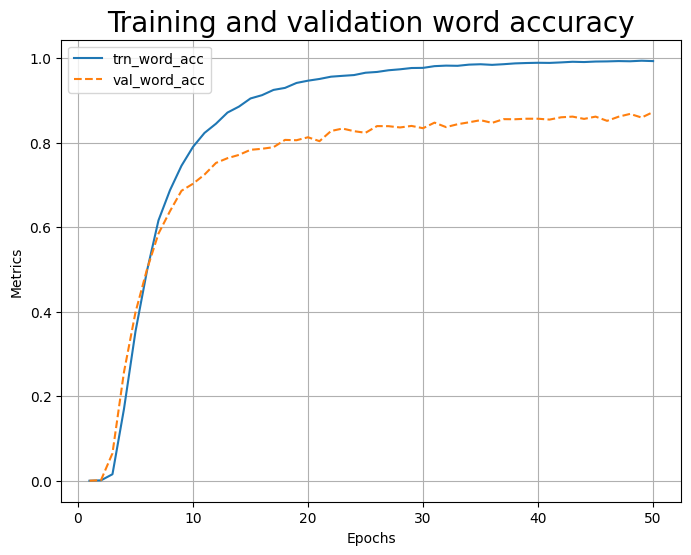

In [38]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')